# 🌱 CropGuard AI — Model Training (PyTorch)

**Dataset:** [20K+ Multi-Class Crop Disease Images](https://www.kaggle.com/datasets/jawadali1045/20k-multi-class-crop-disease-images)  
**Path:** `U:\dataset` (42 classes, pre-split Train/Validation)  
**Model:** MobileNetV2 (Transfer Learning)  
**Runtime:** Python 3.14 + PyTorch

## 1️⃣ Imports & Setup

In [4]:
import os
import json
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_CUDA = device.type == 'cuda'
NON_BLOCKING = USE_CUDA

print(f'PyTorch: {torch.__version__}')
print(f'Device:  {device}')
if USE_CUDA:
    print(f'GPU:     {torch.cuda.get_device_name(0)}')

PyTorch: 2.10.0+cu128
Device:  cuda
GPU:     NVIDIA GeForce RTX 4050 Laptop GPU


## 2️⃣ Dataset Setup

In [5]:
# ── Dataset paths ───────────────────────────────────────────────
DATASET_ROOT = Path(r'U:\dataset')
TRAIN_DIR = DATASET_ROOT / 'Train'
VAL_DIR   = DATASET_ROOT / 'Validation'

print(f'Train dir: {TRAIN_DIR}  (exists: {TRAIN_DIR.exists()})')
print(f'Val dir:   {VAL_DIR}  (exists: {VAL_DIR.exists()})')

# List all classes
classes = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
NUM_CLASSES = len(classes)
print(f'\nFound {NUM_CLASSES} classes:')
for i, c in enumerate(classes):
    train_count = len(list((TRAIN_DIR / c).glob('*')))
    val_count = len(list((VAL_DIR / c).glob('*'))) if (VAL_DIR / c).exists() else 0
    print(f'  {i:2d}. {c:<40s} — Train: {train_count:4d}  Val: {val_count:4d}')

Train dir: U:\dataset\Train  (exists: True)
Val dir:   U:\dataset\Validation  (exists: True)

Found 42 classes:
   0. American Bollworm on Cotton              — Train:   56  Val:   30
   1. Anthracnose on Cotton                    — Train:   29  Val:   10
   2. Army worm                                — Train:   40  Val:  351
   3. Becterial Blight in Rice                 — Train: 1584  Val:   22
   4. Brownspot                                — Train: 1640  Val:    9
   5. Common_Rust                              — Train: 1306  Val:   18
   6. Cotton Aphid                             — Train:   39  Val:  287
   7. Flag Smut                                — Train:  179  Val:   24
   8. Gray_Leaf_Spot                           — Train:  574  Val:   20
   9. Healthy Maize                            — Train: 1162  Val:  275
  10. Healthy Wheat                            — Train:  181  Val:   33
  11. Healthy cotton                           — Train:  426  Val:  176
  12. Leaf Curl         

In [6]:
# ── Config ───────────────────────────────────────────────────────
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 0  # Windows: keep at 0
PIN_MEMORY = USE_CUDA
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

# ── Transforms (ImageNet normalisation) ─────────────────────────
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, scale=(0.85, 1.15)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ── Load datasets ───────────────────────────────────────────────
train_dataset = datasets.ImageFolder(str(TRAIN_DIR), transform=train_transform)
val_dataset   = datasets.ImageFolder(str(VAL_DIR),   transform=val_transform)

CLASS_NAMES = train_dataset.classes
NUM_CLASSES = len(CLASS_NAMES)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f'\n📊 Dataset:')
print(f'   Train:      {len(train_dataset)} images ({len(train_loader)} batches)')
print(f'   Validation: {len(val_dataset)} images ({len(val_loader)} batches)')
print(f'   Classes:    {NUM_CLASSES}')
print(f'   Image size: {IMG_SIZE}x{IMG_SIZE}')
print(f'   Pin memory: {PIN_MEMORY}')


📊 Dataset:
   Train:      15448 images (483 batches)
   Validation: 3171 images (100 batches)
   Classes:    42
   Image size: 224x224
   Pin memory: True


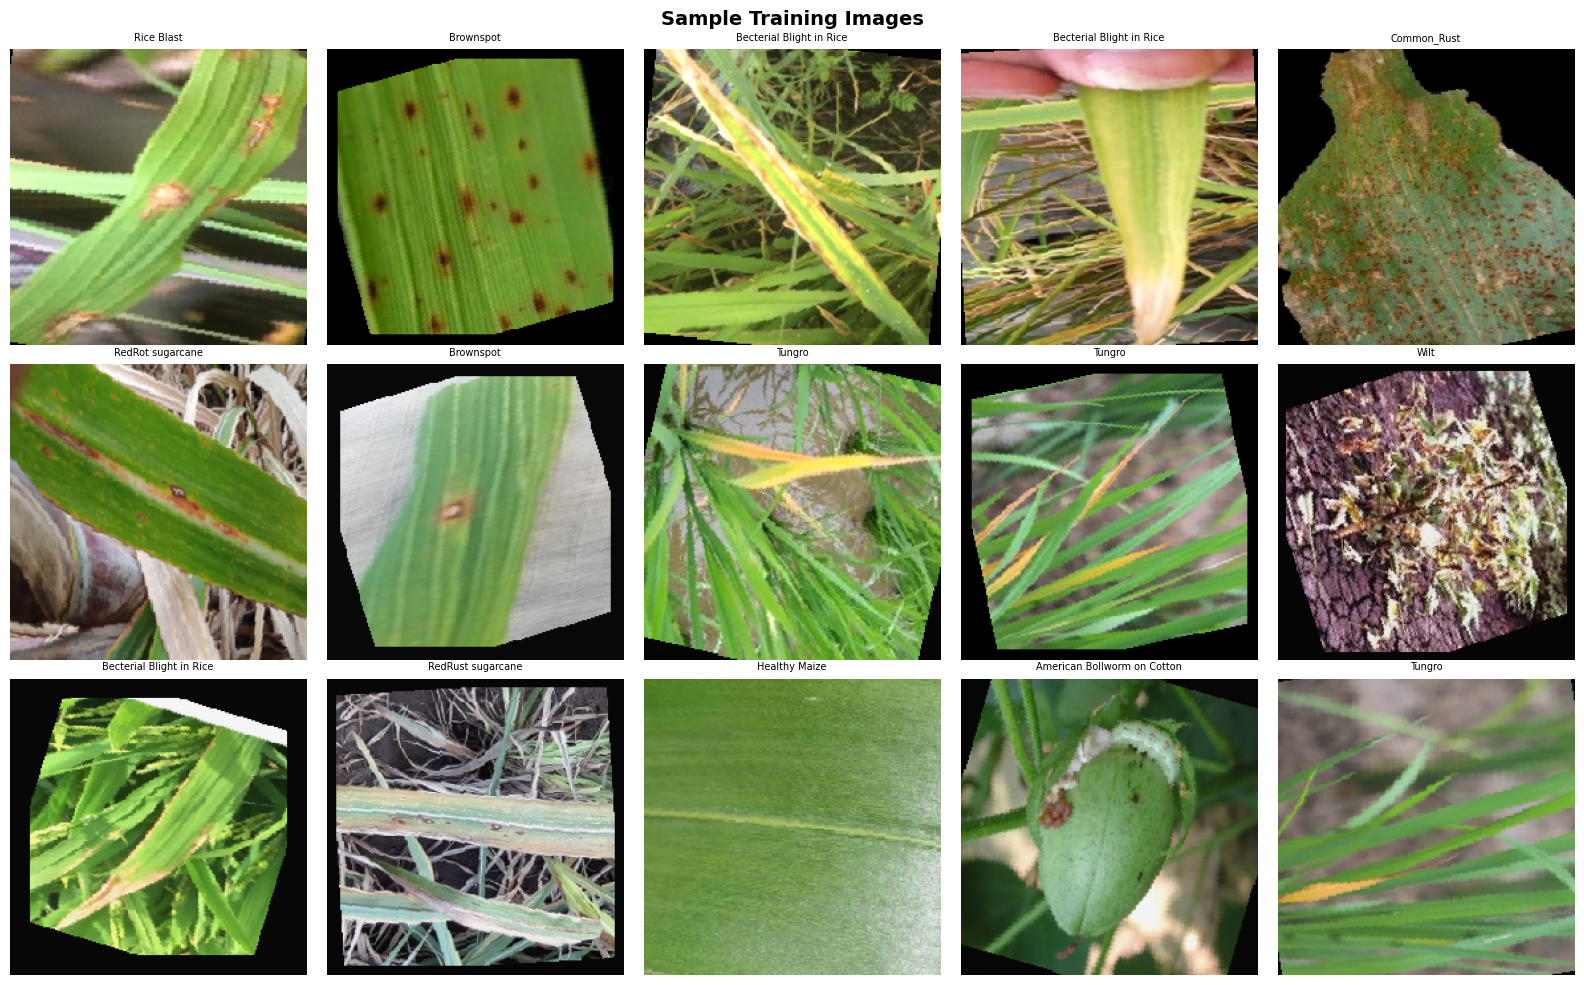

In [7]:
# ── Visualise sample images ─────────────────────────────────────
def denormalize(tensor):
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std  = torch.tensor(IMAGENET_STD).view(3, 1, 1)
    return (tensor * std + mean).clamp(0, 1)

plt.figure(figsize=(16, 10))
images, labels = next(iter(train_loader))
for i in range(min(15, len(images))):
    plt.subplot(3, 5, i + 1)
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(CLASS_NAMES[labels[i]], fontsize=7)
    plt.axis('off')
plt.suptitle('Sample Training Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3️⃣ Build Model — MobileNetV2

In [8]:
# ── Pretrained MobileNetV2 ──────────────────────────────────────
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze all base layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier head for our 42 classes
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, NUM_CLASSES),
)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total params:     {total_params:,}')
print(f'Trainable params: {trainable_params:,}')
print(f'Frozen params:    {total_params - trainable_params:,}')

Total params:     2,562,602
Trainable params: 338,730
Frozen params:    2,223,872


## 4️⃣ Training

In [9]:
# ── Training function ───────────────────────────────────────────
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=5):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        start = time.time()
        
        # ── Train ──────────────────────────────────────────────
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device, non_blocking=NON_BLOCKING)
            labels = labels.to(device, non_blocking=NON_BLOCKING)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            running_total += images.size(0)
            
            # Progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f'  Batch {batch_idx+1}/{len(train_loader)}  '
                      f'loss: {running_loss/running_total:.4f}  '
                      f'acc: {running_correct/running_total:.4f}', end='\r')
        
        train_loss = running_loss / running_total
        train_acc  = running_correct / running_total
        
        # ── Validate ───────────────────────────────────────────
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device, non_blocking=NON_BLOCKING)
                labels = labels.to(device, non_blocking=NON_BLOCKING)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss_sum += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += images.size(0)
        
        val_loss = val_loss_sum / val_total
        val_acc  = val_correct / val_total
        
        scheduler.step(val_loss)
        elapsed = time.time() - start
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1:2d}/{num_epochs}  '
              f'train_loss: {train_loss:.4f}  train_acc: {train_acc:.4f}  '
              f'val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}  '
              f'lr: {lr:.1e}  [{elapsed:.0f}s]')
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'  ✅ New best! (val_acc: {val_acc:.4f})')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'  ⏹ Early stopping ({patience} epochs no improvement)')
                break
    
    model.load_state_dict(best_model_wts)
    print(f'\n🏆 Best val accuracy: {best_acc:.4f}')
    return model, history

In [10]:
# ── Phase 1: Train classifier head (base frozen) ────────────────
print('🏋️ Phase 1: Training classifier head (base frozen)...\n')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

model, history1 = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    num_epochs=15, patience=5
)

🏋️ Phase 1: Training classifier head (base frozen)...



u:\CropGuard AI\.venv\Lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


u:\CropGuard AI\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch  1/15  train_loss: 1.2012  train_acc: 0.6744  val_loss: 6.9602  val_acc: 0.0681  lr: 1.0e-03  [336s]
  ✅ New best! (val_acc: 0.0681)
Epoch  2/15  train_loss: 0.7250  train_acc: 0.7837  val_loss: 7.8977  val_acc: 0.0845  lr: 1.0e-03  [155s]
  ✅ New best! (val_acc: 0.0845)
Epoch  3/15  train_loss: 0.6646  train_acc: 0.8027  val_loss: 8.1761  val_acc: 0.1347  lr: 1.0e-03  [154s]
  ✅ New best! (val_acc: 0.1347)
Epoch  4/15  train_loss: 0.6000  train_acc: 0.8195  val_loss: 8.8472  val_acc: 0.1479  lr: 1.0e-03  [155s]
  ✅ New best! (val_acc: 0.1479)
Epoch  5/15  train_loss: 0.5591  train_acc: 0.8298  val_loss: 8.9274  val_acc: 0.1555  lr: 5.0e-04  [164s]
  ✅ New best! (val_acc: 0.1555)
Epoch  6/15  train_loss: 0.4928  train_acc: 0.8516  val_loss: 9.6897  val_acc: 0.1501  lr: 5.0e-04  [167s]
Epoch  7/15  train_loss: 0.4764  train_acc: 0.8549  val_loss: 9.4940  val_acc: 0.1602  lr: 5.0e-04  [163s]
  ✅ New best! (val_acc: 0.1602)
Epoch  8/15  train_loss: 0.4576  train_acc: 0.8558  val_los

In [11]:
# ── Phase 2: Unfreeze top layers and fine-tune ──────────────────
print('\n🏋️ Phase 2: Fine-tuning top layers...\n')

# Unfreeze last 5 feature blocks
for i, block in enumerate(model.features):
    if i >= 14:
        for param in block.parameters():
            param.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable params: {trainable:,}\n')

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=2, factor=0.5)

model, history2 = train_model(
    model, train_loader, val_loader,
    criterion, optimizer_ft, scheduler_ft,
    num_epochs=15, patience=5
)


🏋️ Phase 2: Fine-tuning top layers...

Trainable params: 2,020,074

Epoch  1/15  train_loss: 0.3318  train_acc: 0.8977  val_loss: 11.7687  val_acc: 0.1962  lr: 1.0e-04  [165s]
  ✅ New best! (val_acc: 0.1962)
Epoch  2/15  train_loss: 0.2405  train_acc: 0.9247  val_loss: 13.2645  val_acc: 0.1965  lr: 1.0e-04  [175s]
  ✅ New best! (val_acc: 0.1965)
Epoch  3/15  train_loss: 0.2022  train_acc: 0.9368  val_loss: 13.7143  val_acc: 0.1990  lr: 1.0e-04  [160s]
  ✅ New best! (val_acc: 0.1990)
Epoch  4/15  train_loss: 0.1719  train_acc: 0.9459  val_loss: 13.3977  val_acc: 0.2044  lr: 5.0e-05  [160s]
  ✅ New best! (val_acc: 0.2044)
Epoch  5/15  train_loss: 0.1245  train_acc: 0.9607  val_loss: 14.8011  val_acc: 0.2107  lr: 5.0e-05  [178s]
  ✅ New best! (val_acc: 0.2107)
Epoch  6/15  train_loss: 0.1197  train_acc: 0.9604  val_loss: 14.5744  val_acc: 0.2081  lr: 5.0e-05  [171s]
Epoch  7/15  train_loss: 0.1055  train_acc: 0.9650  val_loss: 14.9739  val_acc: 0.2189  lr: 2.5e-05  [170s]
  ✅ New best! (

## 5️⃣ Training History

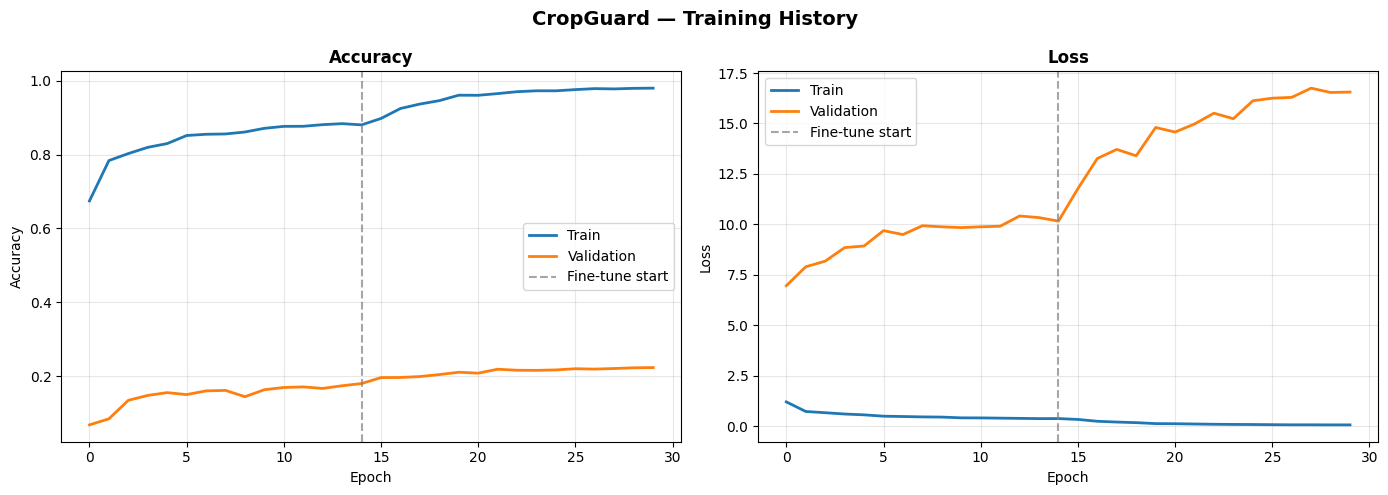

In [12]:
history = {k: history1[k] + history2[k] for k in history1}
phase1_end = len(history1['train_acc']) - 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_acc'], label='Train', linewidth=2)
axes[0].plot(history['val_acc'], label='Validation', linewidth=2)
axes[0].axvline(x=phase1_end, color='gray', linestyle='--', alpha=0.7, label='Fine-tune start')
axes[0].set_title('Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_loss'], label='Train', linewidth=2)
axes[1].plot(history['val_loss'], label='Validation', linewidth=2)
axes[1].axvline(x=phase1_end, color='gray', linestyle='--', alpha=0.7, label='Fine-tune start')
axes[1].set_title('Loss', fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.suptitle('CropGuard — Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 6️⃣ Evaluate

In [13]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    correct, total, loss_sum = 0, 0, 0.0
    for images, labels in val_loader:
        images = images.to(device, non_blocking=NON_BLOCKING)
        labels = labels.to(device, non_blocking=NON_BLOCKING)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss_sum += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_acc  = correct / total
test_loss = loss_sum / total

print(f'🎯 Validation Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)')
print(f'📉 Validation Loss:     {test_loss:.4f}')

print('\n📊 Classification Report')
print('=' * 70)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=3))

🎯 Validation Accuracy: 0.2233 (22.3%)
📉 Validation Loss:     16.5571

📊 Classification Report
                             precision    recall  f1-score   support

American Bollworm on Cotton      0.643     0.900     0.750        30
      Anthracnose on Cotton      0.286     0.600     0.387        10
                  Army worm      0.982     0.929     0.955       351
   Becterial Blight in Rice      0.000     0.000     0.000       284
                  Brownspot      0.000     0.000     0.000        22
                Common_Rust      0.000     0.000     0.000         9
               Cotton Aphid      0.000     0.000     0.000        18
                  Flag Smut      0.000     0.000     0.000       287
             Gray_Leaf_Spot      0.000     0.000     0.000        24
              Healthy Maize      0.000     0.000     0.000        20
              Healthy Wheat      0.021     0.004     0.006       275
             Healthy cotton      0.000     0.000     0.000        33
        

u:\CropGuard AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
u:\CropGuard AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
u:\CropGuard AI\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


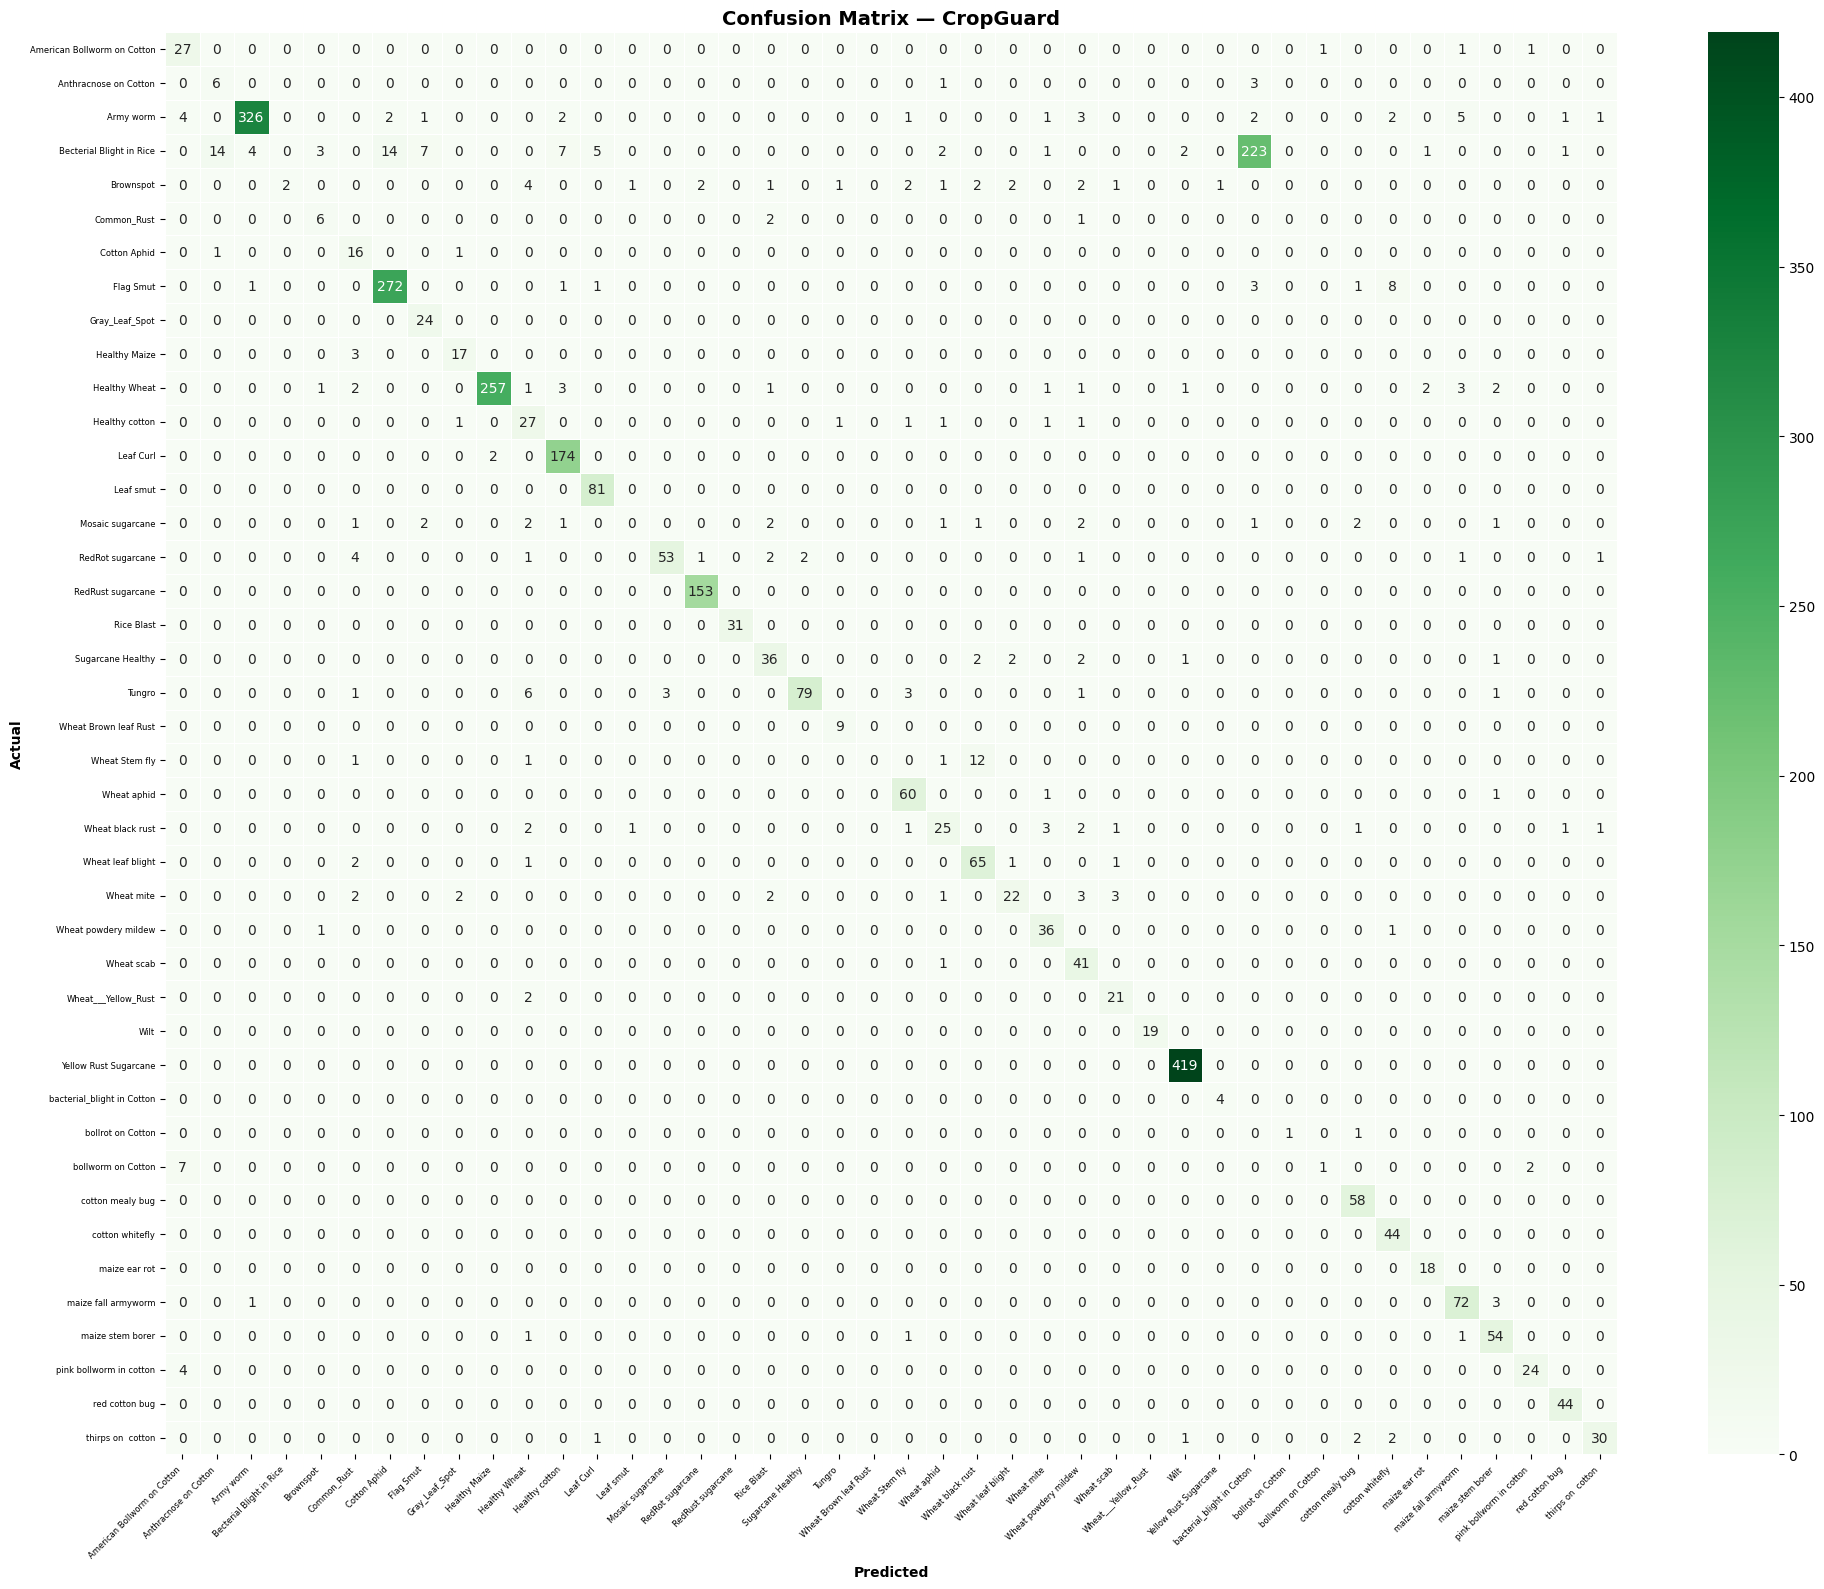

In [14]:
# ── Confusion Matrix ────────────────────────────────────────────
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 16))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Greens',
    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
    linewidths=0.5, linecolor='white',
)
plt.title('Confusion Matrix — CropGuard', fontweight='bold', fontsize=14)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 7️⃣ Export for FastAPI

In [15]:
import shutil

# ── Export directory ─────────────────────────────────────────────
EXPORT_DIR = Path('./export')
EXPORT_DIR.mkdir(exist_ok=True)

# Save as TorchScript
model.eval()
model_cpu = model.cpu()
scripted = torch.jit.script(model_cpu)
model_path = EXPORT_DIR / 'crop_disease_model.pt'
scripted.save(str(model_path))
print(f'✅ Model saved: {model_path} ({model_path.stat().st_size / 1024 / 1024:.1f} MB)')

# Save class map
class_map = {str(i): name for i, name in enumerate(CLASS_NAMES)}
class_map_path = EXPORT_DIR / 'class_map.json'
with open(class_map_path, 'w') as f:
    json.dump(class_map, f, indent=2)
print(f'✅ Class map saved: {class_map_path}')

# ── Copy to Server/model/ ───────────────────────────────────────
server_model_dir = Path(r'U:\CropGuard AI\Server\model')
server_model_dir.mkdir(exist_ok=True)

shutil.copy(model_path, server_model_dir / 'crop_disease_model.pt')
shutil.copy(class_map_path, server_model_dir / 'class_map.json')

print(f'\n📦 Copied to {server_model_dir}/')
print(f'   ├── crop_disease_model.pt')
print(f'   └── class_map.json')

print(f'\n📋 Class mapping ({NUM_CLASSES} classes):')
for idx, name in class_map.items():
    print(f'   {idx:>2s} → {name}')

print(f'\n🚀 Restart FastAPI server → real predictions!')

✅ Model saved: export\crop_disease_model.pt (10.1 MB)
✅ Class map saved: export\class_map.json

📦 Copied to U:\CropGuard AI\Server\model/
   ├── crop_disease_model.pt
   └── class_map.json

📋 Class mapping (42 classes):
    0 → American Bollworm on Cotton
    1 → Anthracnose on Cotton
    2 → Army worm
    3 → Becterial Blight in Rice
    4 → Brownspot
    5 → Common_Rust
    6 → Cotton Aphid
    7 → Flag Smut
    8 → Gray_Leaf_Spot
    9 → Healthy Maize
   10 → Healthy Wheat
   11 → Healthy cotton
   12 → Leaf Curl
   13 → Leaf smut
   14 → Mosaic sugarcane
   15 → RedRot sugarcane
   16 → RedRust sugarcane
   17 → Rice Blast
   18 → Sugarcane Healthy
   19 → Tungro
   20 → Wheat Brown leaf Rust
   21 → Wheat Stem fly
   22 → Wheat aphid
   23 → Wheat black rust
   24 → Wheat leaf blight
   25 → Wheat mite
   26 → Wheat powdery mildew
   27 → Wheat scab
   28 → Wheat___Yellow_Rust
   29 → Wilt
   30 → Yellow Rust Sugarcane
   31 → bacterial_blight in Cotton
   32 → bollrot on Cotton
 

## 📊 Summary

In [16]:
print('═' * 50)
print('  CROPGUARD AI — TRAINING SUMMARY')
print('═' * 50)
print(f'  Framework:  PyTorch {torch.__version__}')
print(f'  Model:      MobileNetV2 (transfer learning)')
print(f'  Dataset:    U:\\dataset (20K+ images)')
print(f'  Classes:    {NUM_CLASSES}')
print(f'  Image size: {IMG_SIZE}x{IMG_SIZE}')
print(f'  Val Acc:    {test_acc:.4f} ({test_acc*100:.1f}%)')
print(f'  Val Loss:   {test_loss:.4f}')
print(f'  Device:     {device}')
print('═' * 50)

══════════════════════════════════════════════════
  CROPGUARD AI — TRAINING SUMMARY
══════════════════════════════════════════════════
  Framework:  PyTorch 2.10.0+cu128
  Model:      MobileNetV2 (transfer learning)
  Dataset:    U:\dataset (20K+ images)
  Classes:    42
  Image size: 224x224
  Val Acc:    0.2233 (22.3%)
  Val Loss:   16.5571
  Device:     cuda
══════════════════════════════════════════════════
